In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import mpld3
import numpy as np
from scipy import stats
import seaborn as sns
from sksos import SOS
from stemgraphic import stem_graphic
import warnings
warnings.filterwarnings('ignore')
sns.set_context('talk')

## Why Scikit-learn?
Scikit-learn's advantage is not necessarily the algorithms that are available. In fact, the bar is [quite high](http://scikit-learn.org/stable/faq.html#what-are-the-inclusion-criteria-for-new-algorithms) for code to be included in the library, and is missing several important tools. No, the real advantage is the consistent API. This is well established, allowing for complex pipelines and ensembles, and is well respected, to the point where other libraries provide an sklearn api. Ex:
* [Keras](https://keras.io/scikit-learn-api/)
* [xgboost](http://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)
* [lightning](https://github.com/scikit-learn-contrib/lightning)
* [lsanomaly](https://github.com/lsanomaly/lsanomaly)
* [scikit-sos](https://github.com/jeroenjanssens/scikit-sos)
* [yellowbrick](http://www.scikit-yb.org/en/latest/) and [many more](https://github.com/scikit-learn-contrib/scikit-learn-contrib)


# little bits of data. It's all just electrons

Before we go into specific ML algorithms, fitting models and running some predictions, let's look at data. (original 1.7GB zip file on [cms.gov](http://www.cms.gov/apps/ama/license.asp?file=http://download.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Downloads/Medicare_Provider_Util_Payment_PUF_CY2012_update.zip))

In [2]:
medicare = pd.read_table("../data/Medicare_Provider_Util_Payment_PUF_CY2012.txt",
                         skiprows=[1], header=0)

This is the same dataset I introduced in my [stemgraphic talk](https://www.youtube.com/watch?v=-4h8U_I-tzo) (around the 10min mark, see also the associated distribution plots [notebook](https://github.com/fdion/stemgraphic/blob/master/notebooks/distribution_plots.ipynb)) at PyData Carolinas

In [3]:
medicare.columns

Index(['NPI', 'NPPES_PROVIDER_LAST_ORG_NAME', 'NPPES_PROVIDER_FIRST_NAME',
       'NPPES_PROVIDER_MI', 'NPPES_CREDENTIALS', 'NPPES_PROVIDER_GENDER',
       'NPPES_ENTITY_CODE', 'NPPES_PROVIDER_STREET1', 'NPPES_PROVIDER_STREET2',
       'NPPES_PROVIDER_CITY', 'NPPES_PROVIDER_ZIP', 'NPPES_PROVIDER_STATE',
       'NPPES_PROVIDER_COUNTRY', 'PROVIDER_TYPE',
       'MEDICARE_PARTICIPATION_INDICATOR', 'PLACE_OF_SERVICE', 'HCPCS_CODE',
       'HCPCS_DESCRIPTION', 'HCPCS_DRUG_INDICATOR', 'LINE_SRVC_CNT',
       'BENE_UNIQUE_CNT', 'BENE_DAY_SRVC_CNT', 'AVERAGE_MEDICARE_ALLOWED_AMT',
       'STDEV_MEDICARE_ALLOWED_AMT', 'AVERAGE_SUBMITTED_CHRG_AMT',
       'STDEV_SUBMITTED_CHRG_AMT', 'AVERAGE_MEDICARE_PAYMENT_AMT',
       'STDEV_MEDICARE_PAYMENT_AMT'],
      dtype='object')

## Stemgraphic
<img src='../images/stemgraphic_logo.png'> Before getting into scikit-learn, let's learn more about the data with graphical stem and leaf plots ([stemgraphic.org](http://stemgraphic.org))

(<matplotlib.figure.Figure at 0x13a96c208>,
 <matplotlib.axes._axes.Axes at 0x13a96c9b0>)

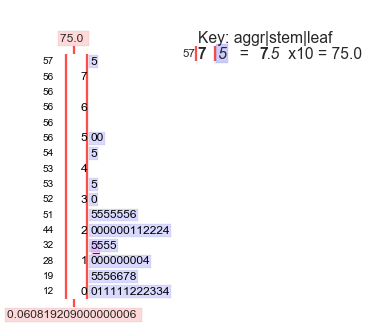

In [4]:
# J0171: administration of injection, epipen
code = 'J0171'
stem_graphic(medicare[medicare.HCPCS_CODE==code].AVERAGE_SUBMITTED_CHRG_AMT)

(<matplotlib.figure.Figure at 0x10b5ae7b8>,
 <matplotlib.axes._axes.Axes at 0x10b5b4320>)

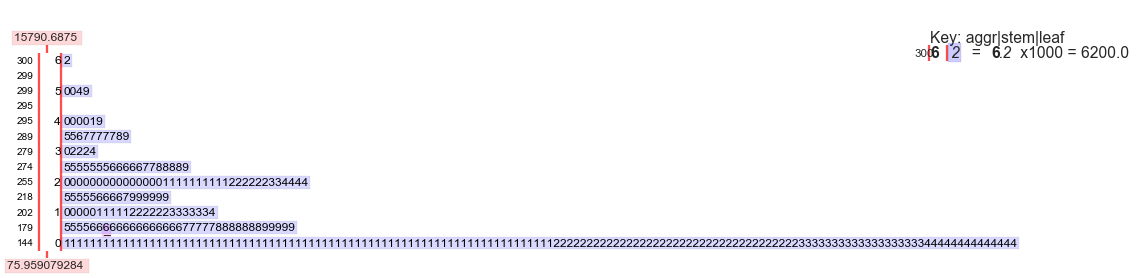

In [5]:
# J3490: Drugs unclassified injection
stem_graphic(medicare[(medicare.HCPCS_CODE=='J3490') &
                      (medicare.AVERAGE_SUBMITTED_CHRG_AMT > 75)].AVERAGE_SUBMITTED_CHRG_AMT,
             display=300, random_state=1234)

# Heatmaps

Again, visualization from seaborn. If you need large scale, use multiple stemgraphic plots (with dask) or use [datashader](http://datashader.readthedocs.io/en/latest/).

In [6]:
inj = medicare[medicare.HCPCS_CODE=='J3490']
features = [ 'AVERAGE_MEDICARE_ALLOWED_AMT',
       'STDEV_MEDICARE_ALLOWED_AMT', 'AVERAGE_SUBMITTED_CHRG_AMT',
       'STDEV_SUBMITTED_CHRG_AMT', 'AVERAGE_MEDICARE_PAYMENT_AMT',
       'STDEV_MEDICARE_PAYMENT_AMT']

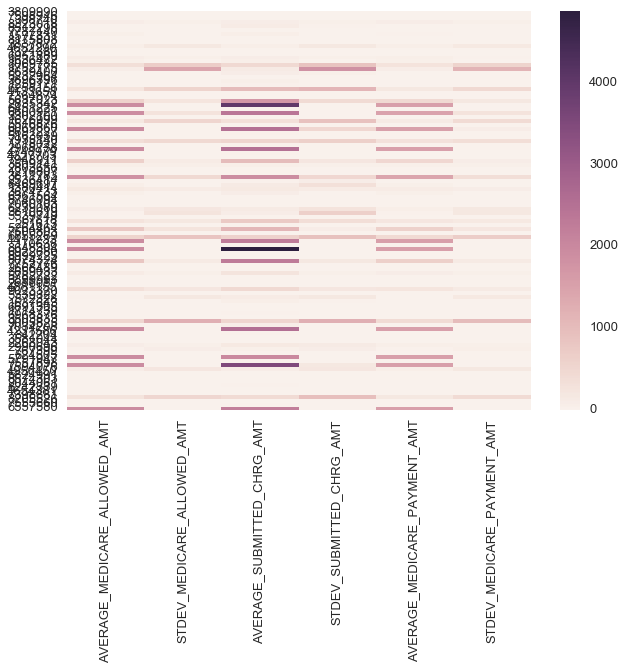

In [7]:
g = sns.heatmap(data=inj[features].sample(replace=False, n=100))

# Pointplot

A point plot represents an estimate of central tendency for a numeric variable by the position of scatter plot points and provides some indication of the uncertainty around that estimate using error bars.

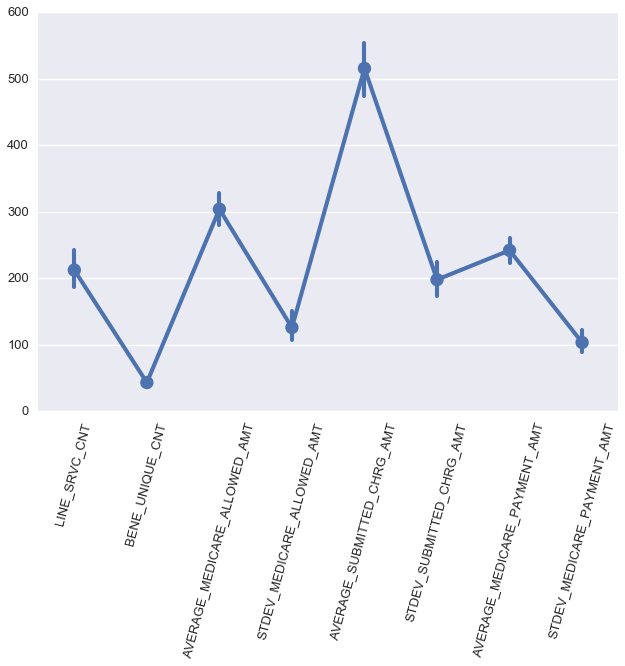

In [33]:
g = sns.pointplot(data=inj[features])
for item in g.get_xticklabels(): item.set_rotation(75)

In [9]:
features = [ 'LINE_SRVC_CNT',
       'BENE_UNIQUE_CNT','AVERAGE_MEDICARE_ALLOWED_AMT',
       'STDEV_MEDICARE_ALLOWED_AMT', 'AVERAGE_SUBMITTED_CHRG_AMT',
       'STDEV_SUBMITTED_CHRG_AMT', 'AVERAGE_MEDICARE_PAYMENT_AMT',
       'STDEV_MEDICARE_PAYMENT_AMT']
inj.shape

(3209, 28)

## Flatland (in two dimensions)

Reducing data to two or three (2.5, really) dimensions. Scikit-learn provides various ways to do this. Perhaps it could be as simple as reducing features down to 2 using RFE or using cluster.FeatureAgglomeration. There's also the classic decomposition.PCA as featured by Hollywood :)

(see [_numb3rs season 2, episode 11_](http://www.imdb.com/title/tt0663227/)) 

<img src="../images/numb3rs_211.png">

There are a few other options, such as TruncatedSVD (LSI or latent semantic analysis) for __sparse__ data. 

I'm sure most are familiar with PCA, so instead we'll start with [t-sne](https://lvdmaaten.github.io/tsne/) here, or if you preder in long form, __t-Distributed Stochastic Neighbor Embedding__.

In [10]:
from sklearn.manifold import TSNE

In [11]:
tsne = TSNE(2, random_state=6)

In [12]:
data_2d = tsne.fit_transform(inj[features])

In [13]:
data_2d[:5]

array([[  5.22530904,   0.26358494],
       [  2.41130973,  -7.85692902],
       [ -5.31411733,  16.55061979],
       [ 12.71764125,   7.29095033],
       [  3.98367251,  -8.11986161]])

In [14]:
x = data_2d[:,0]
y = data_2d[:,1]

In [15]:
colors = [i for i,_ in enumerate(inj.index)]

# Jointplot
More seaborn visualizations (_the intro talked about distribution analysis in 1d, here we deal with 2d, with marginal plots and contour lines_)

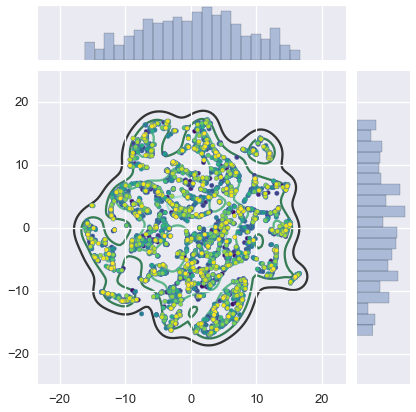

In [16]:
g = (sns.jointplot(x=x, y=y, stat_func=None,
                   c=colors, cmap='viridis').plot_joint(sns.kdeplot, zorder=0, n_levels=4))

The above is just to illustrate the fact that multiple level kde lines can be added to the seaborn jointplot. It doesn't make a lot of sense with t-sne, since it is the clustering that is relevant, not the distance from center. The point that just happen to be outside the external kde line is an outlier, not because it is there, but because it is a lone point with nothing close in the neighborhood. In the next cell we look at this data point using an index.

How did we figure out the index? See mpld3 use in notebook 03.

In [18]:
inj.ix[3885151]

NPI                                         1427050079
NPPES_PROVIDER_LAST_ORG_NAME                     JOUDI
NPPES_PROVIDER_FIRST_NAME                         FADI
NPPES_PROVIDER_MI                                    N
NPPES_CREDENTIALS                                   MD
NPPES_PROVIDER_GENDER                                M
NPPES_ENTITY_CODE                                    I
NPPES_PROVIDER_STREET1                  2626 N WEBB RD
NPPES_PROVIDER_STREET2                             NaN
NPPES_PROVIDER_CITY                            WICHITA
NPPES_PROVIDER_ZIP                           672268110
NPPES_PROVIDER_STATE                                KS
NPPES_PROVIDER_COUNTRY                              US
PROVIDER_TYPE                                  Urology
MEDICARE_PARTICIPATION_INDICATOR                     Y
PLACE_OF_SERVICE                                     O
HCPCS_CODE                                       J3490
HCPCS_DESCRIPTION                   Unclassified drugs
HCPCS_DRUG

## We are the robots
Alright, cool visual stuff. But what about machine learning? Two possible options

* class imbalance -> [imbalanced-learn](https://github.com/scikit-learn-contrib/imbalanced-learn)
* one class classifiers ([overview](http://scikit-learn.org/stable/modules/outlier_detection.html)):

<img src='../images/sample.png'>

I didn't cover LOF in the above, but if you are interested in it, it is in the current development branch of scikit-learn: [v.019dev0](http://scikit-learn.org/dev/auto_examples/neighbors/plot_lof.html). And of course, there are many other options, ranging from MCMC, to spectral ranking. A search on github will yield many scikit "compatible" options.

Let's get back to PCA, and use one of scikit-learn's tool for detecting outliers:

### EllipticEnvelope

In [19]:
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope

In [20]:
pca = PCA(n_components=2, whiten=True)

pca.fit(inj[features])
data_2d = pca.transform(inj[features])
x1 = data_2d[:,0]
y1 = data_2d[:,1]

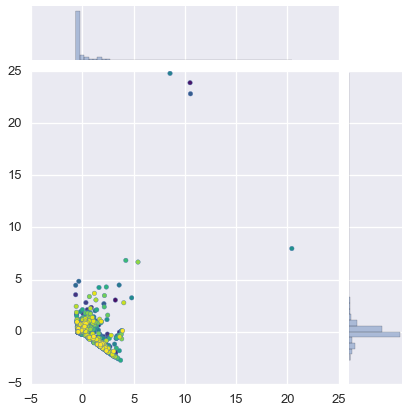

In [21]:
g = sns.jointplot(x=x1, y=y1, c=colors, cmap='viridis', stat_func=None)

In [22]:
COUNT = 6
clf = EllipticEnvelope(contamination=COUNT/len(inj))

In [23]:
clf.fit(data_2d)  # first using data_2d from tsne, then pca_2d from PCA

EllipticEnvelope(assume_centered=False, contamination=0.001869741352446245,
         random_state=None, store_precision=True, support_fraction=None)

In [24]:
y_pred = clf.predict(data_2d)

In [25]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [26]:
inj[y_pred==-1]

,NPI,NPPES_PROVIDER_LAST_ORG_NAME,NPPES_PROVIDER_FIRST_NAME,NPPES_PROVIDER_MI,NPPES_CREDENTIALS,NPPES_PROVIDER_GENDER,NPPES_ENTITY_CODE,NPPES_PROVIDER_STREET1,NPPES_PROVIDER_STREET2,NPPES_PROVIDER_CITY,...,HCPCS_DRUG_INDICATOR,LINE_SRVC_CNT,BENE_UNIQUE_CNT,BENE_DAY_SRVC_CNT,AVERAGE_MEDICARE_ALLOWED_AMT,STDEV_MEDICARE_ALLOWED_AMT,AVERAGE_SUBMITTED_CHRG_AMT,STDEV_SUBMITTED_CHRG_AMT,AVERAGE_MEDICARE_PAYMENT_AMT,STDEV_MEDICARE_PAYMENT_AMT
529768,1053486704,WILLIS,KENNETH,D,M.D.,M,I,600 WHITESPORT CIR SW,NaN,HUNTSVILLE,...,N,816.0,128,187,3425.390931,16982.897939,3428.886029,16981.392599,2740.001078,13586.321547
2650774,1285805713,STOKES,OSCAR,J,"M.D., M.S.",M,I,1300 UPPER HEMBREE RD,"BUILDING 100, SUITE B",ROSWELL,...,N,1864.0,187,501,3791.209764,16290.969036,3791.481760,16290.738600,3031.568509,13030.182687
4018601,1437268489,MCCOOMER,NORMAN,NaN,MD,M,I,460 LANIER RD,SUITE 206,MADISON,...,N,2489.0,156,293,1642.125536,16621.146210,1644.918039,16618.924344,1313.132386,13296.054816
4568950,1497863500,LARISEY,WALTER,E,M.D.,M,I,600 WHITESPORT CIR SW,NaN,HUNTSVILLE,...,N,16.0,16,16,15790.687500,11668.980738,15790.687500,11668.980738,12630.148750,9337.697492
6148894,1679511661,CHAWLA,SAMEER,N,M.D.,M,I,3000 NEW BERN AVE,"ANDREWS CENTER, 3RD FLOOR",RALEIGH,...,N,139.0,17,34,172.555396,530.030121,4226.244604,12446.424428,137.562014,423.167521
7525883,1821041674,AKBIK,HAMMAM,H,MD,M,I,3050 MACK RD,NaN,FAIRFIELD,...,N,20.0,13,20,2410.827000,4413.706111,4211.150000,7729.090420,1928.661500,3530.964942


## Dare to compare?

Let's see if SOS ([Stochastic Outlier Selection (pdf)](https://github.com/jeroenjanssens/sos/blob/master/doc/sos-ticc-tr-2012-001.pdf?raw=true)) and T-SNE ([t-distributed stochastic neighbor embedding](https://lvdmaaten.github.io/tsne/)) overlap when it comes to outliers (or try comparing with other clustering techniques)

In [28]:
clf = SOS()

In [29]:
y_pred = clf.predict(inj[features].values)

In [30]:
sorted(y_pred)[-10:]

[0.89445846025546427,
 0.89908063555869933,
 0.90058063238753328,
 0.91271671524025522,
 0.91380600400154688,
 0.93441287394487571,
 0.94642858805196217,
 0.95542852622784757,
 0.99110298439530764,
 0.99850589851418647]

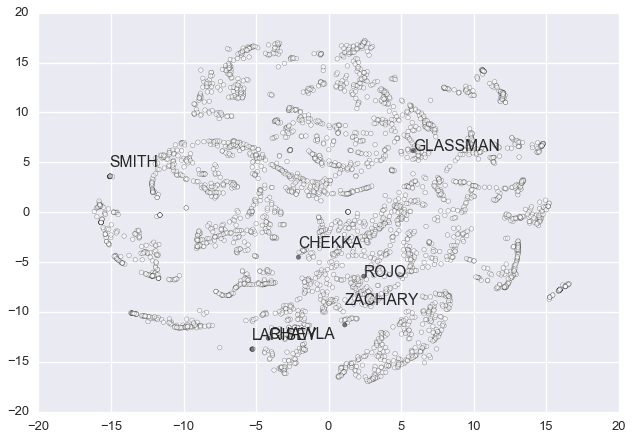

In [31]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(x, y, c=(y_pred>0.902), cmap='binary', alpha=0.5)
for i, name in enumerate(inj.NPPES_PROVIDER_LAST_ORG_NAME):
    if y_pred[i]>0.902:
        ax.annotate(name,(x[i], y[i]+i%3))